# **Comment Toxicity Model**

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import nltk
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.models import load_model
import warnings

2024-09-18 11:39:59.545710: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 11:39:59.545774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 11:39:59.546585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 11:39:59.551789: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 11:40:00.252469: W tensorflow/compiler/tf2

In [2]:
import sys
sys.setrecursionlimit(1500) 

In [3]:
# ignoring all warnings

warnings.filterwarnings('ignore')

In [4]:
# reading data

df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# checking for shape of dataset, null values and duplicates 

print(df.shape)
print('-----------------------')
print(df.isnull().sum())
print('-----------------------')
df.duplicated().sum()

(159571, 8)
-----------------------
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
-----------------------


0

In [6]:
# creating list for columns and values
columns_to_plot = df.columns[2:]
values = []
for col in columns_to_plot:
    values.append(len(df[df[col]==1])/len(df)*100)


In [7]:
# sorting lists

sorted_data = sorted(zip(columns_to_plot, values), key= lambda x:x[1], reverse=True)
sorted_categories, sorted_values = zip(*sorted_data)

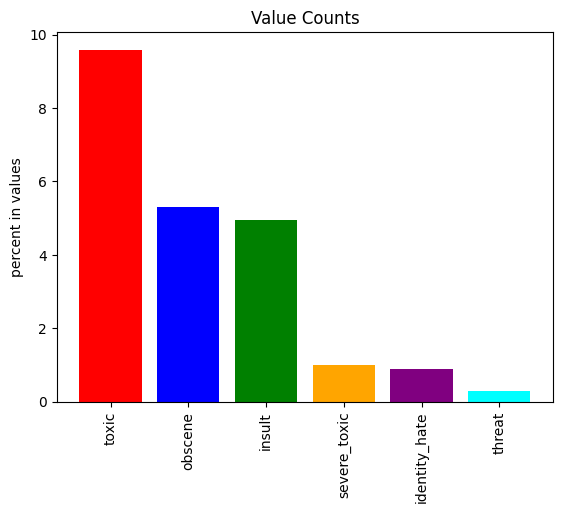

In [8]:
# plotting data

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
plt.bar(sorted_categories, sorted_values, color=colors)
plt.ylabel('percent in values')
plt.xticks(rotation=90)
plt.title('Value Counts')
plt.show()

## Text Preprocessing

In [9]:
# defining a function for preprocessing text


def preprocess(q):
    
    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', '')
    q = q.replace('$', '')
    q = q.replace('₹', '')
    q = q.replace('@', '')
    q = q.replace('-', '')
    q = q.replace('?', '')
    q = re.sub(r'\d+', '',q)

    q = q.replace('[UNK]', '')

    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "abt": "about",
    "can't": "can not",
    "can't've": "can not have",
    "cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "d' aww": "aww",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "u": "you",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]
        q_decontracted.append(word.strip())

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    return q

In [10]:
# applying preprocessing function 

df['comment_text'] = df['comment_text'].apply(preprocess)

In [12]:
# splitting into X and y

X = df['comment_text']
y = df[df.columns[2:]].values

In [13]:
# max number of features

MAX_FEATURES = 200000

In [14]:
# vectorizing text

vectorizer = TextVectorization(max_tokens=MAX_FEATURES, 
                               output_sequence_length=1800,
                               output_mode='int')

2024-09-18 11:40:22.570436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-18 11:40:22.769337: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-18 11:40:22.769482: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-18 11:40:22.772491: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-18 11:40:22.772554: I external/local_xla/xla/stream_executor

In [15]:
# training vectorizer on our own data

vectorizer.adapt(X.values)

In [16]:
# vectorizing our text datad

vectorized_text = vectorizer(X.values)

2024-09-18 11:40:34.280238: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-18 11:40:34.721347: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.


In [17]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  640,    76,     2, ...,     0,     0,     0],
       [  428, 16247,    51, ...,     0,     0,     0],
       [  389,   415,     4, ...,     0,     0,     0],
       ...,
       [28763,  6829,  4809, ...,     0,     0,     0],
       [    6,    12,   536, ...,     0,     0,     0],
       [    6,     4,   132, ...,     0,     0,     0]])>

In [18]:
# creating a dataset pipeline

dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(320000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(8)

In [19]:
data_len = len(dataset)

In [20]:
# splitting dataset into training, testing and validation 

train = dataset.take(int(data_len*0.7))
val = dataset.skip(int(data_len*0.7)).take(int(data_len*0.2))
test = dataset.skip(int(data_len*0.9)).take(int(data_len))

In [21]:
# creating numpy iterator of training datad

train_generator = train.as_numpy_iterator()

2024-09-18 11:40:44.811820: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.


## Create Sequential Model

In [22]:
# importing libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [23]:
# building an archetecture

model = Sequential()

model.add(Embedding(MAX_FEATURES+1, 100))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))


In [27]:
# summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         20000100  
                                                                 
 bidirectional (Bidirection  (None, 64)                34048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [28]:
# compiling model

model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy'])

In [29]:
# training model

hist = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
3490/3490 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9881

2024-09-18 11:52:18.051596: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.


3490/3490 [==============================] - 756s 216ms/step - loss: 0.0590 - accuracy: 0.9881 - val_loss: 0.0485 - val_accuracy: 0.9940
Epoch 2/5
3490/3490 [==============================] - 885s 253ms/step - loss: 0.0455 - accuracy: 0.9939 - val_loss: 0.0386 - val_accuracy: 0.9940
Epoch 3/5
3490/3490 [==============================] - 1033s 296ms/step - loss: 0.0395 - accuracy: 0.9942 - val_loss: 0.0353 - val_accuracy: 0.9944
Epoch 4/5
3490/3490 [==============================] - 1041s 298ms/step - loss: 0.0342 - accuracy: 0.9942 - val_loss: 0.0306 - val_accuracy: 0.9938
Epoch 5/5
3490/3490 [==============================] - 1041s 298ms/step - loss: 0.0293 - accuracy: 0.9936 - val_loss: 0.0239 - val_accuracy: 0.9941


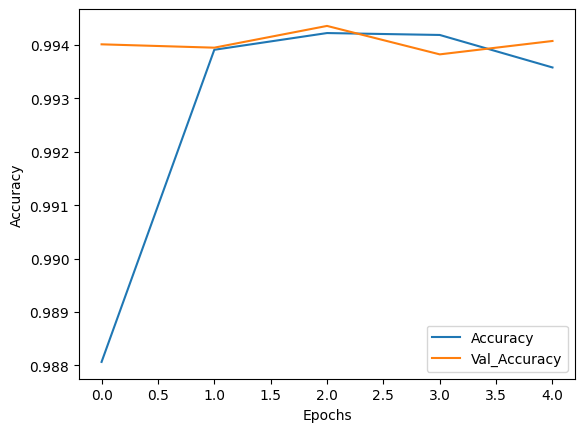

In [30]:
# plotting accuracy curve

plt.plot(hist.history['accuracy'], label='Accuracy')
plt.plot(hist.history['val_accuracy'], label='Val_Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

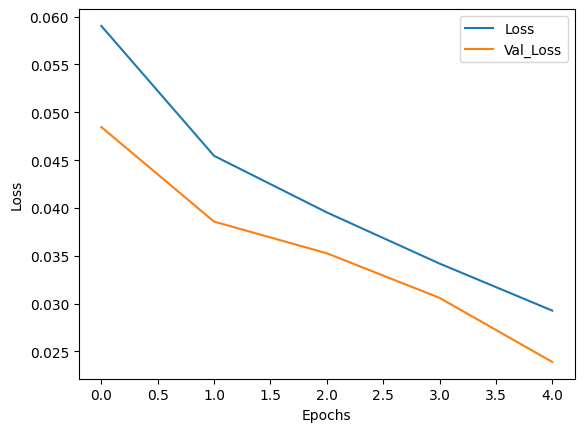

In [31]:
# plotting loss curve

plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Val_Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
# model = load_model('toxic.h5')

In [33]:
# testing model on user input

input_text = vectorizer(preprocess("You are a most idiot person I have ever seen"))

In [34]:
# making predictions

model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 1s 1s/step


array([[0.9823229 , 0.01346508, 0.6692352 , 0.00476472, 0.8466251 ,
        0.03103793]], dtype=float32)

In [35]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

## Model Evaluation

In [36]:
# testing data

test_batch_x, test_batch_y = test.as_numpy_iterator().next()

2024-09-18 13:00:32.788368: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.


In [37]:
test_batch_y

array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [38]:
# making predictions on test data

(model.predict(test_batch_x)>=0.5).astype('int')

1/1 [==============================] - 0s 328ms/step


array([[0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [43]:
# precision, recall and accuracy of model 

pre = Precision()
rec = Recall()
acc = CategoricalAccuracy()

In [44]:
# calculating precision, recall and accuracy

for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    y_hat = model.predict(X_true)

    y_true = y_true.flatten()
    y_hat = y_hat.flatten()

    pre.update_state(y_true, y_hat)
    rec.update_state(y_true, y_hat)
    acc.update_state(y_true, y_hat)

1/1 [==============================] - 0s 91ms/step


In [45]:
print(f'Precesion: {pre.result().numpy()}, Recall: {rec.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precesion: 0.8870090842247009, Recall: 0.8515081405639648, Accuracy: 0.37274548411369324


In [46]:
model.save('toxic.h5')